In [72]:
# import Oracle_Assignment_2 as oa
# import requests
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
# oa.q2_get_mnist_jpg_subset(23634)


In [73]:

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset



In [74]:

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure grayscale
    transforms.ToTensor(),  # Convert to tensor
])


In [75]:



dataset = datasets.ImageFolder(root="q2_data", transform=transform)

# Split dataset into training and test sets (80-20 split)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [76]:


def evaluate(model, train_loader, test_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%")
    correct, total = 0, 0
    with torch.no_grad() :
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f"Train Accuracy: {100 * correct / total:.2f}%")


def train(model, train_loader, criterion, optimizer, device, epochs, test_loader):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()  # Update weights using SGD with momentum

            total_loss += loss.item()

        # evaluate(model, train_loader, test_loader, device)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")


def metricslearn(model, train_loader, test_loader, device):
    model.eval()
    y_pred = []
    y_true = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.tolist())
            y_true.extend(labels.tolist())
    
    print("Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))


def dataloader_to_numpy(dataloader):
    data_list = []
    labels_list = []

    for images, labels in dataloader:
        images = images.numpy().reshape(images.shape[0], -1)
        data_list.append(images)
        labels_list.append(labels.numpy())

    data_array = np.vstack(data_list)
    labels_array = np.concatenate(labels_list)
    return data_array, labels_array

train_data, train_labels = dataloader_to_numpy(train_loader)
test_data, test_labels = dataloader_to_numpy(test_loader)


def pca(data, k) :
    cov_matrix = np.cov(data.T)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    idx = np.argsort(eigenvalues)[::-1]


    eigenvectors = eigenvectors[:, idx]
    eigenvalues = eigenvalues[idx]
    eigenvecks = eigenvectors[:, :k]
    new_data = np.dot(data, eigenvecks)
    return new_data, eigenvecks




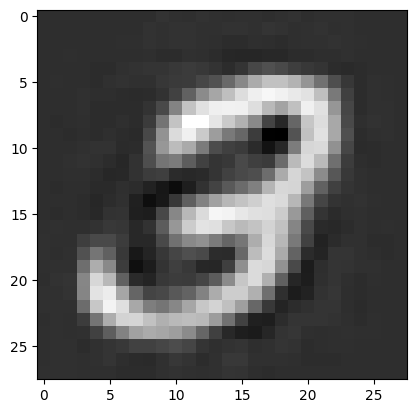

In [77]:


mean = np.mean(train_data, axis=0)
std = np.std(train_data, axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std
k = 100
train_data_pca, eigenvecks = pca(train_data, k)
test_data_pca = np.dot(test_data, eigenvecks)



# Convert PCA-transformed data to tensors
train_data_pca_tensor = torch.tensor(train_data_pca, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_data_pca_tensor = torch.tensor(test_data_pca, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create TensorDataset and DataLoader
train_pca_dataset = TensorDataset(train_data_pca_tensor, train_labels_tensor)
test_pca_dataset = TensorDataset(test_data_pca_tensor, test_labels_tensor)

train_pca_loader = DataLoader(train_pca_dataset, batch_size=32, shuffle=True)
test_pca_loader = DataLoader(test_pca_dataset, batch_size=32, shuffle=False)

# Reconstruct a sample image
sample = train_data_pca[10]
reconstructed = np.dot(sample, eigenvecks.T)
reconstructed = (reconstructed * std) + mean
reconstructed = reconstructed.reshape(28, 28)
plt.imshow(reconstructed, cmap="gray")

 


In [78]:
from kan import *
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model = KAN(width=[100,50,20,10],grid =5 ,k=3,seed=42,device=device).to(device)



checkpoint directory created: ./model
saving model version 0.0


In [79]:

len(train_pca_dataset)
for i in train_pca_dataset:
    print (i)
    break


# train(model,train_data_pca)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
train(model, train_pca_loader, criterion, optimizer, device, epochs=20, test_loader = test_pca_loader)



model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")




(tensor([-2.0472,  7.9613, -2.2898,  3.4429, -5.2726, -0.3485, -0.4050,  2.1357,
         1.0681,  2.1077, -4.3549, -1.8591, -3.9294,  1.3441,  4.5603,  3.2952,
        -3.4873,  3.1178,  3.6384, -2.1361,  1.6275,  0.9159,  0.6815,  3.2301,
        -1.6479, -1.0020, -0.3372, -0.1730, -1.6207, -1.5034, -3.4637,  1.4142,
         2.0428,  0.4206,  1.7206, -1.0217,  2.6869,  0.2338,  0.5618, -0.1682,
         0.5383,  0.2283, -2.6073,  0.5335,  0.7564,  1.8830, -2.7475,  1.8364,
        -0.1861, -1.5521, -0.3408, -0.4720,  0.6496,  1.8955, -2.9937,  1.9011,
         1.6762, -0.5243, -1.0073, -0.9713, -1.0559,  1.1607,  1.3263, -0.3726,
        -1.7560,  0.6479, -0.4303, -0.6862, -1.3399,  0.1349, -0.6564, -1.2059,
        -1.6218, -1.6516,  0.6206,  2.6700, -1.2187, -1.7361,  0.6729, -1.4730,
         0.5212,  2.0538, -1.4799,  2.4743, -1.2621,  2.5354,  0.3375, -1.1828,
        -0.4938,  0.2449,  0.4972,  0.1283, -0.4411,  0.1275, -0.2815, -0.5866,
         0.2212,  0.8003,  1.2902,  0.2

In [80]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")
correct, total = 0, 0
with torch.no_grad() :
    for images, labels in train_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f"Train Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 90.40%
Train Accuracy: 98.85%


In [81]:
mlp_depth_2_accuracy = []
mlp_depth_2_params = []
mlp_depth_3_accuracy = []
mlp_depth_3_params = []

In [82]:
#60042
#log(60042)=11.002
class MLPPCA_depth2_1(nn.Module):
    def __init__(self):
        super(MLPPCA_depth2_1, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
modelMLPPCA_depth2_1 = MLPPCA_depth2_1()


modelMLPPCA_depth2_1 = MLPPCA_depth2_1().to("cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.LBFGS(modelMLPPCA_depth2_1.parameters(), lr=0.01)
def closure():
    optimizer.zero_grad()
    output = modelMLPPCA_depth2_1(train_data_pca_tensor)
    loss = criterion(output, train_labels_tensor)
    loss.backward()
    return loss

for _ in range(18):
    optimizer.step(closure)
    with torch.no_grad():
        output = modelMLPPCA_depth2_1(train_data_pca_tensor)
        loss = criterion(output, train_labels_tensor)
        print(f"Loss: {loss.item()}")


# train(modelMLPPCA, train_pca_loader, criterion, optimizer, "cpu", epochs=17, test_loader = test_pca_loader)
# metricslearn(modelMLPPCA, train_pca_loader, test_pca_loader, "cpu")
modelMLPPCA_depth2_1.eval()
correct, total = 0, 0
device=torch.device("cpu")
with torch.no_grad():
    for images, labels in test_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelMLPPCA_depth2_1(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")
mlp_depth_2_accuracy.append(100 * correct / total)
correct, total = 0, 0
with torch.no_grad() :
    for images, labels in train_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelMLPPCA_depth2_1(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f"Train Accuracy: {100 * correct / total:.2f}%")
mlp_depth_2_params.append(sum(p.numel() for p in modelMLPPCA_depth2_1.parameters()))

 

Loss: 1.3155112266540527
Loss: 0.7003046274185181
Loss: 0.4663151800632477
Loss: 0.3210848569869995
Loss: 0.22004643082618713
Loss: 0.15033870935440063
Loss: 0.10295000672340393
Loss: 0.07139943540096283
Loss: 0.04969947040081024
Loss: 0.035012226551771164
Loss: 0.025088120251893997
Loss: 0.018262332305312157
Loss: 0.013442904688417912
Loss: 0.009973364882171154
Loss: 0.007506389636546373
Loss: 0.005676924251019955
Loss: 0.004385603591799736
Loss: 0.003417552914470434
Test Accuracy: 95.05%
Train Accuracy: 100.00%


In [83]:
#94218
#log(94218)=11.4533
class MLPPCA_depth2_2(nn.Module):
    def __init__(self):
        super(MLPPCA_depth2_2, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
        )


    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
modelMLPPCA_depth2_3 = MLPPCA_depth2_2()


modelMLPPCA_depth2_3 = MLPPCA_depth2_2().to("cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.LBFGS(modelMLPPCA_depth2_3.parameters(), lr=0.01)
def closure():
    optimizer.zero_grad()
    output = modelMLPPCA_depth2_3(train_data_pca_tensor)
    loss = criterion(output, train_labels_tensor)
    loss.backward()
    return loss

for _ in range(18):
    optimizer.step(closure)
    with torch.no_grad():
        output = modelMLPPCA_depth2_3(train_data_pca_tensor)
        loss = criterion(output, train_labels_tensor)
        print(f"Loss: {loss.item()}")


# train(modelMLPPCA, train_pca_loader, criterion, optimizer, "cpu", epochs=17, test_loader = test_pca_loader)
# metricslearn(modelMLPPCA, train_pca_loader, test_pca_loader, "cpu")
modelMLPPCA_depth2_3.eval()
correct, total = 0, 0
device=torch.device("cpu")
with torch.no_grad():
    for images, labels in test_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelMLPPCA_depth2_3(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")
mlp_depth_2_accuracy.append(100 * correct / total)
correct, total = 0, 0
with torch.no_grad() :
    for images, labels in train_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelMLPPCA_depth2_3(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f"Train Accuracy: {100 * correct / total:.2f}%")
mlp_depth_2_params.append(sum(p.numel() for p in modelMLPPCA_depth2_3.parameters()))

Loss: 1.364985704421997
Loss: 0.7094522714614868
Loss: 0.47116586565971375
Loss: 0.3267822861671448
Loss: 0.2247580885887146
Loss: 0.1536889225244522
Loss: 0.10562749952077866
Loss: 0.07351047545671463
Loss: 0.05147329717874527
Loss: 0.03632853180170059
Loss: 0.025747232139110565
Loss: 0.018514318391680717
Loss: 0.013491916470229626
Loss: 0.009963429532945156
Loss: 0.0073765036650002
Loss: 0.005534439813345671
Loss: 0.004184778314083815
Loss: 0.0031697016675025225
Test Accuracy: 95.15%
Train Accuracy: 100.00%


In [84]:

#118666
#log(118666)=11.684
class MLPPCA_depth2_3(nn.Module):
    def __init__(self):
        super(MLPPCA_depth2_3, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(100, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
modelMLPPCA_depth2_3 = MLPPCA_depth2_3()


modelMLPPCA_depth2_3 = MLPPCA_depth2_3().to("cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.LBFGS(modelMLPPCA_depth2_3.parameters(), lr=0.01)
def closure():
    optimizer.zero_grad()
    output = modelMLPPCA_depth2_3(train_data_pca_tensor)
    loss = criterion(output, train_labels_tensor)
    loss.backward()
    return loss

for _ in range(18):
    optimizer.step(closure)
    with torch.no_grad():
        output = modelMLPPCA_depth2_3(train_data_pca_tensor)
        loss = criterion(output, train_labels_tensor)
        print(f"Loss: {loss.item()}")


# train(modelMLPPCA, train_pca_loader, criterion, optimizer, "cpu", epochs=17, test_loader = test_pca_loader)
# metricslearn(modelMLPPCA, train_pca_loader, test_pca_loader, "cpu")
modelMLPPCA_depth2_3.eval()
correct, total = 0, 0
device=torch.device("cpu")
with torch.no_grad():
    for images, labels in test_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelMLPPCA_depth2_3(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")
mlp_depth_2_accuracy.append(100 * correct / total)
correct, total = 0, 0
with torch.no_grad() :
    for images, labels in train_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelMLPPCA_depth2_3(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f"Train Accuracy: {100 * correct / total:.2f}%")
mlp_depth_2_params.append(sum(p.numel() for p in modelMLPPCA_depth2_3.parameters()))

 

 

Loss: 1.3678239583969116
Loss: 0.741801917552948
Loss: 0.507179319858551
Loss: 0.3568466603755951
Loss: 0.25135985016822815
Loss: 0.1744108647108078
Loss: 0.12009458988904953
Loss: 0.08336998522281647
Loss: 0.05805347487330437
Loss: 0.040488384664058685
Loss: 0.028613587841391563
Loss: 0.020741336047649384
Loss: 0.015217003412544727
Loss: 0.011230384930968285
Loss: 0.008375987410545349
Loss: 0.006282424554228783
Loss: 0.0047720349393785
Loss: 0.0036143530160188675
Test Accuracy: 95.10%
Train Accuracy: 100.00%


In [85]:
#94218
#log(94218)=11.4533
class MLPPCA_depth2_4(nn.Module):
    def __init__(self):
        super(MLPPCA_depth2_4, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(100, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
        )


    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
modelMLPPCA_depth2_4 = MLPPCA_depth2_4()


modelMLPPCA_depth2_4 = MLPPCA_depth2_4().to("cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.LBFGS(modelMLPPCA_depth2_4.parameters(), lr=0.01)
def closure():
    optimizer.zero_grad()
    output = modelMLPPCA_depth2_4(train_data_pca_tensor)
    loss = criterion(output, train_labels_tensor)
    loss.backward()
    return loss

for _ in range(18):
    optimizer.step(closure)
    with torch.no_grad():
        output = modelMLPPCA_depth2_4(train_data_pca_tensor)
        loss = criterion(output, train_labels_tensor)
        print(f"Loss: {loss.item()}")


# train(modelMLPPCA, train_pca_loader, criterion, optimizer, "cpu", epochs=17, test_loader = test_pca_loader)
# metricslearn(modelMLPPCA, train_pca_loader, test_pca_loader, "cpu")
modelMLPPCA_depth2_4.eval()
correct, total = 0, 0
device=torch.device("cpu")
with torch.no_grad():
    for images, labels in test_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelMLPPCA_depth2_4(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")
mlp_depth_2_accuracy.append(100 * correct / total)
correct, total = 0, 0
with torch.no_grad() :
    for images, labels in train_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelMLPPCA_depth2_4(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f"Train Accuracy: {100 * correct / total:.2f}%")
mlp_depth_2_params.append(sum(p.numel() for p in modelMLPPCA_depth2_4.parameters()))

Loss: 1.2859901189804077
Loss: 0.7254341840744019
Loss: 0.48985666036605835
Loss: 0.33972954750061035
Loss: 0.2363123744726181
Loss: 0.161993607878685
Loss: 0.11027854681015015
Loss: 0.07609770447015762
Loss: 0.05302547290921211
Loss: 0.03736063838005066
Loss: 0.02655201591551304
Loss: 0.019200606271624565
Loss: 0.013986671343445778
Loss: 0.01032550074160099
Loss: 0.007691556122153997
Loss: 0.005808466114103794
Loss: 0.004412159323692322
Loss: 0.0033822820987552404
Test Accuracy: 95.20%
Train Accuracy: 100.00%


In [86]:
#23594
class MLPPCA_depth3_1(nn.Module):
    def __init__(self):
        super(MLPPCA_depth3_1, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(100, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
modelMLPPCA_depth3_1 = MLPPCA_depth3_1()


modelMLPPCA_depth3_1 = MLPPCA_depth3_1().to("cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.LBFGS(modelMLPPCA_depth3_1.parameters(), lr=0.01)
def closure():
    optimizer.zero_grad()
    output = modelMLPPCA_depth3_1(train_data_pca_tensor)
    loss = criterion(output, train_labels_tensor)
    loss.backward()
    return loss

for _ in range(18):
    optimizer.step(closure)
    with torch.no_grad():
        output = modelMLPPCA_depth3_1(train_data_pca_tensor)
        loss = criterion(output, train_labels_tensor)
        print(f"Loss: {loss.item()}")


# train(modelMLPPCA, train_pca_loader, criterion, optimizer, "cpu", epochs=17, test_loader = test_pca_loader)
# metricslearn(modelMLPPCA, train_pca_loader, test_pca_loader, "cpu")
modelMLPPCA_depth3_1.eval()
correct, total = 0, 0
device=torch.device("cpu")
with torch.no_grad():
    for images, labels in test_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelMLPPCA_depth3_1(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")
mlp_depth_3_accuracy.append(100 * correct / total)
correct, total = 0, 0
with torch.no_grad() :
    for images, labels in train_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelMLPPCA_depth3_1(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f"Train Accuracy: {100 * correct / total:.2f}%")
mlp_depth_3_params.append(sum(p.numel() for p in modelMLPPCA_depth3_1.parameters()))


Loss: 1.4370802640914917
Loss: 1.2181564569473267
Loss: 1.06468665599823
Loss: 0.8750242590904236
Loss: 0.6994346380233765
Loss: 0.531578540802002
Loss: 0.3989524841308594
Loss: 0.3001445233821869
Loss: 0.2388395220041275
Loss: 0.19254374504089355
Loss: 0.15858183801174164
Loss: 0.1278415322303772
Loss: 0.10107092559337616
Loss: 0.08060454577207565
Loss: 0.06489771604537964
Loss: 0.04981953278183937
Loss: 0.038554441183805466
Loss: 0.029515083879232407
Test Accuracy: 92.75%
Train Accuracy: 99.34%


In [87]:
#67658
class MLPPCA_depth3_2(nn.Module):
    def __init__(self):
        super(MLPPCA_depth3_2, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
modelMLPPCA_depth3_2 = MLPPCA_depth3_2()


modelMLPPCA_depth3_2 = MLPPCA_depth3_2().to("cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.LBFGS(modelMLPPCA_depth3_2.parameters(), lr=0.01)
def closure():
    optimizer.zero_grad()
    output = modelMLPPCA_depth3_2(train_data_pca_tensor)
    loss = criterion(output, train_labels_tensor)
    loss.backward()
    return loss

for _ in range(18):
    optimizer.step(closure)
    with torch.no_grad():
        output = modelMLPPCA_depth3_2(train_data_pca_tensor)
        loss = criterion(output, train_labels_tensor)
        print(f"Loss: {loss.item()}")


# train(modelMLPPCA, train_pca_loader, criterion, optimizer, "cpu", epochs=17, test_loader = test_pca_loader)
# metricslearn(modelMLPPCA, train_pca_loader, test_pca_loader, "cpu")
modelMLPPCA_depth3_2.eval()
correct, total = 0, 0
device=torch.device("cpu")
with torch.no_grad():
    for images, labels in test_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelMLPPCA_depth3_2(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")
mlp_depth_3_accuracy.append(100 * correct / total)
correct, total = 0, 0
with torch.no_grad() :
    for images, labels in train_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelMLPPCA_depth3_2(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f"Train Accuracy: {100 * correct / total:.2f}%")
mlp_depth_3_params.append(sum(p.numel() for p in modelMLPPCA_depth3_2.parameters()))


Loss: 1.5734601020812988
Loss: 0.9414067268371582
Loss: 0.6886835098266602
Loss: 0.5196483135223389
Loss: 0.3895128667354584
Loss: 0.29149097204208374
Loss: 0.21743836998939514
Loss: 0.1678680032491684
Loss: 0.12922252714633942
Loss: 0.09701035916805267
Loss: 0.07316019386053085
Loss: 0.05289241299033165
Loss: 0.038132619112730026
Loss: 0.026680991053581238
Loss: 0.018667642027139664
Loss: 0.012931952252984047
Loss: 0.00901182834059
Loss: 0.006406106054782867
Test Accuracy: 94.25%
Train Accuracy: 99.96%


In [88]:
#126282
#log(126282)=11.726
class MLPPCA_depth3_3(nn.Module):
    def __init__(self):
        super(MLPPCA_depth3_3, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(100, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
modelMLPPCA_depth3_3 = MLPPCA_depth3_3()


modelMLPPCA_depth3_3 = MLPPCA_depth3_3().to("cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.LBFGS(modelMLPPCA_depth3_3.parameters(), lr=0.01)
def closure():
    optimizer.zero_grad()
    output = modelMLPPCA_depth3_3(train_data_pca_tensor)
    loss = criterion(output, train_labels_tensor)
    loss.backward()
    return loss

for _ in range(18):
    optimizer.step(closure)
    with torch.no_grad():
        output = modelMLPPCA_depth3_3(train_data_pca_tensor)
        loss = criterion(output, train_labels_tensor)
        print(f"Loss: {loss.item()}")


# train(modelMLPPCA, train_pca_loader, criterion, optimizer, "cpu", epochs=17, test_loader = test_pca_loader)
# metricslearn(modelMLPPCA, train_pca_loader, test_pca_loader, "cpu")
modelMLPPCA_depth3_3.eval()
correct, total = 0, 0
device=torch.device("cpu")
with torch.no_grad():
    for images, labels in test_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelMLPPCA_depth3_3(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")
mlp_depth_3_accuracy.append(100 * correct / total)
correct, total = 0, 0
with torch.no_grad() :
    for images, labels in train_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelMLPPCA_depth3_3(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f"Train Accuracy: {100 * correct / total:.2f}%")
mlp_depth_3_params.append(sum(p.numel() for p in modelMLPPCA_depth3_3.parameters()))


Loss: 1.6020598411560059
Loss: 1.1763205528259277
Loss: 0.8798123002052307
Loss: 0.6847692728042603
Loss: 0.5230985879898071
Loss: 0.4029345214366913
Loss: 0.3111810088157654
Loss: 0.2377958744764328
Loss: 0.18045158684253693
Loss: 0.13773106038570404
Loss: 0.10369715839624405
Loss: 0.07719428837299347
Loss: 0.05615866184234619
Loss: 0.0396391898393631
Loss: 0.02790021151304245
Loss: 0.019698122516274452
Loss: 0.01365740317851305
Loss: 0.009756331332027912
Test Accuracy: 93.95%
Train Accuracy: 99.83%


In [89]:
#217226
#log(217226)=12.049
class MLPPCA_depth3_4(nn.Module):
    def __init__(self):
        super(MLPPCA_depth3_4, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(100, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
modelMLPPCA_depth3_4 = MLPPCA_depth3_4()


modelMLPPCA_depth3_4 = MLPPCA_depth3_4().to("cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.LBFGS(modelMLPPCA_depth3_4.parameters(), lr=0.01)
def closure():
    optimizer.zero_grad()
    output = modelMLPPCA_depth3_4(train_data_pca_tensor)
    loss = criterion(output, train_labels_tensor)
    loss.backward()
    return loss

for _ in range(18):
    optimizer.step(closure)
    with torch.no_grad():
        output = modelMLPPCA_depth3_4(train_data_pca_tensor)
        loss = criterion(output, train_labels_tensor)
        print(f"Loss: {loss.item()}")


# train(modelMLPPCA, train_pca_loader, criterion, optimizer, "cpu", epochs=17, test_loader = test_pca_loader)
# metricslearn(modelMLPPCA, train_pca_loader, test_pca_loader, "cpu")
modelMLPPCA_depth3_4.eval()
correct, total = 0, 0
device=torch.device("cpu")
with torch.no_grad():
    for images, labels in test_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelMLPPCA_depth3_4(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")
mlp_depth_3_accuracy.append(100 * correct / total)
correct, total = 0, 0
with torch.no_grad() :
    for images, labels in train_pca_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modelMLPPCA_depth3_4(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f"Train Accuracy: {100 * correct / total:.2f}%")
mlp_depth_3_params.append(sum(p.numel() for p in modelMLPPCA_depth3_4.parameters()))


Loss: 1.6432578563690186
Loss: 0.8761357069015503
Loss: 0.6170578598976135
Loss: 0.4451581835746765
Loss: 0.32758021354675293
Loss: 0.23625193536281586
Loss: 0.16341759264469147
Loss: 0.11446834355592728
Loss: 0.07903002947568893
Loss: 0.054441455751657486
Loss: 0.03707524389028549
Loss: 0.025539731606841087
Loss: 0.01792503334581852
Loss: 0.012807690538465977
Loss: 0.009284639731049538
Loss: 0.006842233240604401
Loss: 0.005105642601847649
Loss: 0.003805155400186777
Test Accuracy: 94.90%
Train Accuracy: 99.99%


In [90]:
# count = 0

# for p in model.parameters():
#     if p.requires_grad:
#       p_count = p.numel()
#       count += p_count

# print("Number of parameters for kan model =", count)
# # print("The time taken to train for kan model =", end1-start1)

# # count = 0

# # for p in mlp_model.parameters():
# #     if p.requires_grad:
# #       p_count = p.numel()
# #       count += p_count

# # print("Number of parameters for mlp model =", count)
# # print("The time taken to train for mlp model =", end2-start2)

In [ ]:
# from kan import *
# # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
# new_model = KAN(width=[100,10,20,10],grid =5 ,k=3,seed=42,device=device).to(device)
# count = 0

# for p in new_model.parameters():
#     if p.requires_grad:
#       p_count = p.numel()
#       count += p_count

# print("Number of parameters for kan model =", count)


In [103]:
from kan import *
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
new_model = KAN(width=[100,90,50,10],grid =5 ,k=3,seed=42,device=device).to(device)
count = 0

for p in new_model.parameters():
    if p.requires_grad:
      p_count = p.numel()
      count += p_count

print("Number of parameters for kan model =", count)


checkpoint directory created: ./model
saving model version 0.0
Number of parameters for kan model = 196000


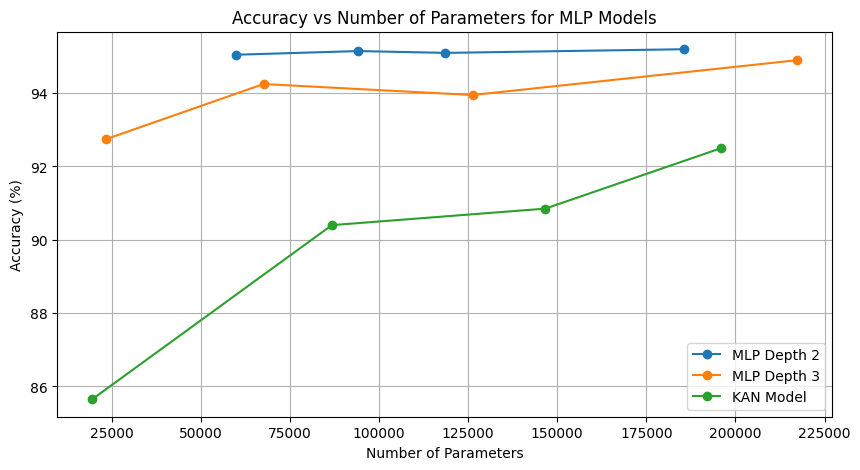

In [104]:
##plot100,10,20,10],[100,50,20,10],[100,75,35,10],[100,90,50,10]
# plot num_params v/s accuracy
plt.figure(figsize=(10, 5))
plt.plot(mlp_depth_2_params, mlp_depth_2_accuracy, label='MLP Depth 2', marker='o')
plt.plot(mlp_depth_3_params, mlp_depth_3_accuracy, label='MLP Depth 3', marker='o')
plt.plot([19600,86800,146650,196000],[85.65,90.40,90.85,92.50], marker ='o', label='KAN Model')
plt.xlabel('Number of Parameters')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Number of Parameters for MLP Models')
plt.legend(loc='lower right')
plt.grid()
plt.savefig('mlp_accuracy_vs_params.png')
plt.show()

In [105]:
print("MLP Depth 2 Accuracy:", mlp_depth_2_accuracy)
print("MLP Depth 2 Parameters:", mlp_depth_2_params)
print("MLP Depth 3 Accuracy:", mlp_depth_3_accuracy)
print("MLP Depth 3 Parameters:", mlp_depth_3_params)


MLP Depth 2 Accuracy: [95.05, 95.15, 95.1, 95.2]
MLP Depth 2 Parameters: [60042, 94218, 118666, 185610]
MLP Depth 3 Accuracy: [92.75, 94.25, 93.95, 94.9]
MLP Depth 3 Parameters: [23594, 67658, 126282, 217226]
